### Preprocessing

In [1]:
# import relevant statistical packages
import numpy as np
import pandas as pd

In [2]:
# pandas version
pd.__version__

'1.4.2'

In [3]:
# import data visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 8.a. Generating normally distribution predictor X and noise vector $\epsilon$

In [4]:
# set random seed for reproducibility
np.random.seed(1)

X = np.random.normal(size=100)
epsilon = np.random.normal(size=100)

In [5]:
len(X), len(epsilon)

(100, 100)

### 8.b. Generating response vector $Y$ = $\beta_0$ + $\beta_1$ $X$ + $\beta_2$ $X^2$ + $\beta_3$ $X^3$ + $\epsilon$

In [6]:
BETA0 = 2.0
BETA1 = -2.0
BETA2 = 3.0
BETA3 = 2.5
Y = BETA0 + (BETA1*X) + (BETA2*pow(X, 2)) + (BETA3*pow(X, 3)) + epsilon

In [7]:
df = pd.DataFrame([X, Y]).T
df.columns = ['X', 'Y']
df.head()

,X,Y
0,1.624345,16.934254
1,-0.611756,4.998390
2,-0.528172,3.928377
3,-1.072969,5.105132
4,0.865408,3.041389


### 8.c. Best subset selection

Using `mlxtend` package to perform feature selection and plotting steps

Source: https://rasbt.github.io/mlxtend/

In [8]:
# import custom packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_linear_regression as PLS
from sklearn.metrics import mean_squared_error

In [9]:
dfX = pd.DataFrame([X, pow(X, 2), pow(X, 3), pow(X, 4), pow(X, 5), pow(X, 6), pow(X, 7), pow(X, 8), pow(X, 9), pow(X, 10)]).T
dfX.columns = ['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
dfX.head()

,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,1.624345,2.638498,4.285832,6.961671,11.308158,18.368354,29.836551,48.464863,78.723675,127.874436
1,-0.611756,0.374246,-0.228947,0.140060,-0.085683,0.052417,-0.032066,0.019617,-0.012001,0.007342
2,-0.528172,0.278965,-0.147342,0.077822,-0.041103,0.021710,-0.011466,0.006056,-0.003199,0.001689
3,-1.072969,1.151262,-1.235268,1.325403,-1.422116,1.525886,-1.637228,1.756694,-1.884878,2.022415
4,0.865408,0.748930,0.648130,0.560897,0.485404,0.420073,0.363534,0.314605,0.272262,0.235617


In [10]:
dfY = pd.DataFrame(df['Y'])
dfY.head()

,Y
0,16.934254
1,4.998390
2,3.928377
3,5.105132
4,3.041389


In [11]:
lm = LinearRegression()
efs = EFS(lm, min_features=1, max_features=10, scoring='r2', cv=10).fit(dfX, dfY)

Features: 1023/1023

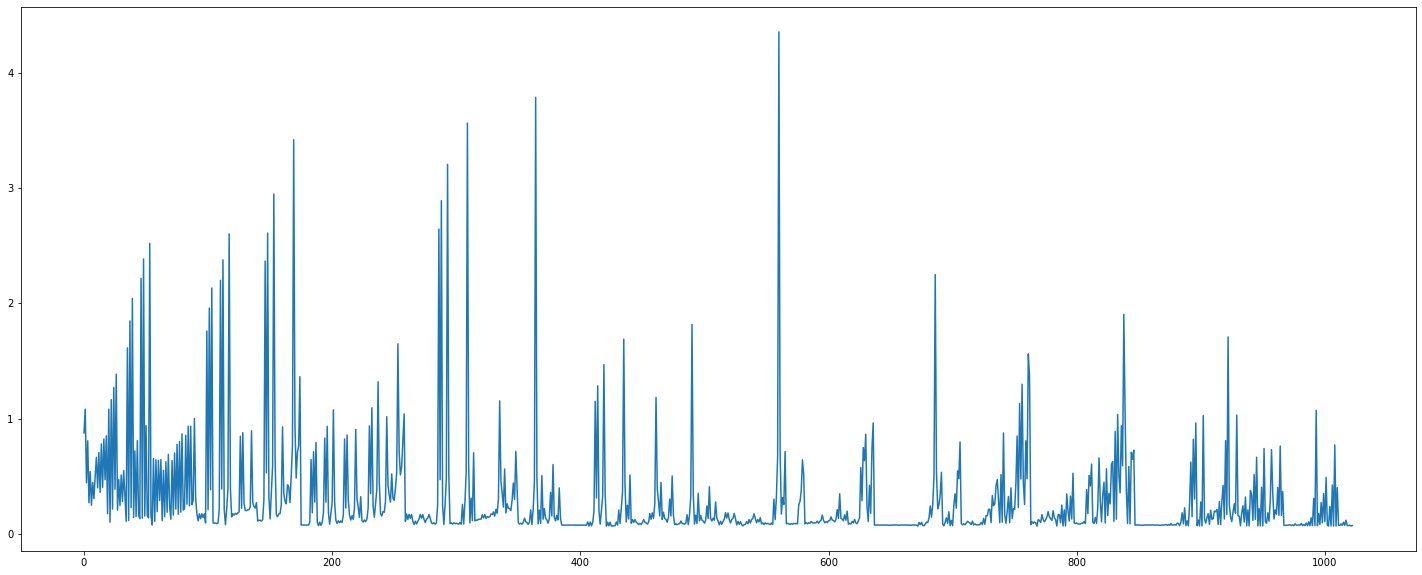

In [12]:
SCORE = pd.DataFrame()
for k in efs.get_metric_dict():
    score = efs.get_metric_dict()[k]['std_err']
    SCORE = SCORE.append([score])

SCORE.columns = ['std err']
SCORE.reset_index(drop=True, inplace=True)

# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(SCORE)

In [13]:
minSCORE = SCORE.loc[SCORE['std err'] == min(SCORE['std err'])]
minSCORE

,std err
768,0.071578


In [14]:
efs.subsets_[768]

{'feature_idx': (1, 2, 3, 4, 6, 8),
 'cv_scores': array([0.84262719, 0.91231559, 0.40774032, 0.96847156, 0.99794416,
        0.37709335, 0.99279323, 0.77323705, 0.79769031, 0.67810813]),
 'avg_score': 0.774802089029847,
 'feature_names': ('X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^9')}

In [15]:
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X,0,-1.650824
1,X^2,1,-1.005807
2,X^5,4,-0.284058
3,X^7,6,-0.313605
4,X^9,8,-0.418940
5,X^10,9,-1.034789


In [16]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-1.340851,2.298519
1,X^2,2.617578,2.298519
2,X^5,2.279830,2.298519
3,X^7,-0.684882,2.298519
4,X^9,0.065720,NaN
5,X^10,0.001195,NaN


In [17]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.776


**Therefore, the best equation through best subset selection is $Y$ = 2.298519 - 1.340851 $X$ + 2.617579 $X^2$ + 2.27983 $X^5$ - 0.684882 $X^7$ + 0.06572 $X^9$ + 0.001195 $X^{10}$ and the mean squared error is 0.776.**

### 8.c. Forward stepwise selection and backward stepwise selection

**Forward stepwise selection**

In [18]:
# import custom packages
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [37]:
lmf = LinearRegression()
sfs = SFS(lmf, k_features=(1,len(dfX.columns)), forward=True, floating=False, scoring='r2',cv=5).fit(dfX.values, dfY)

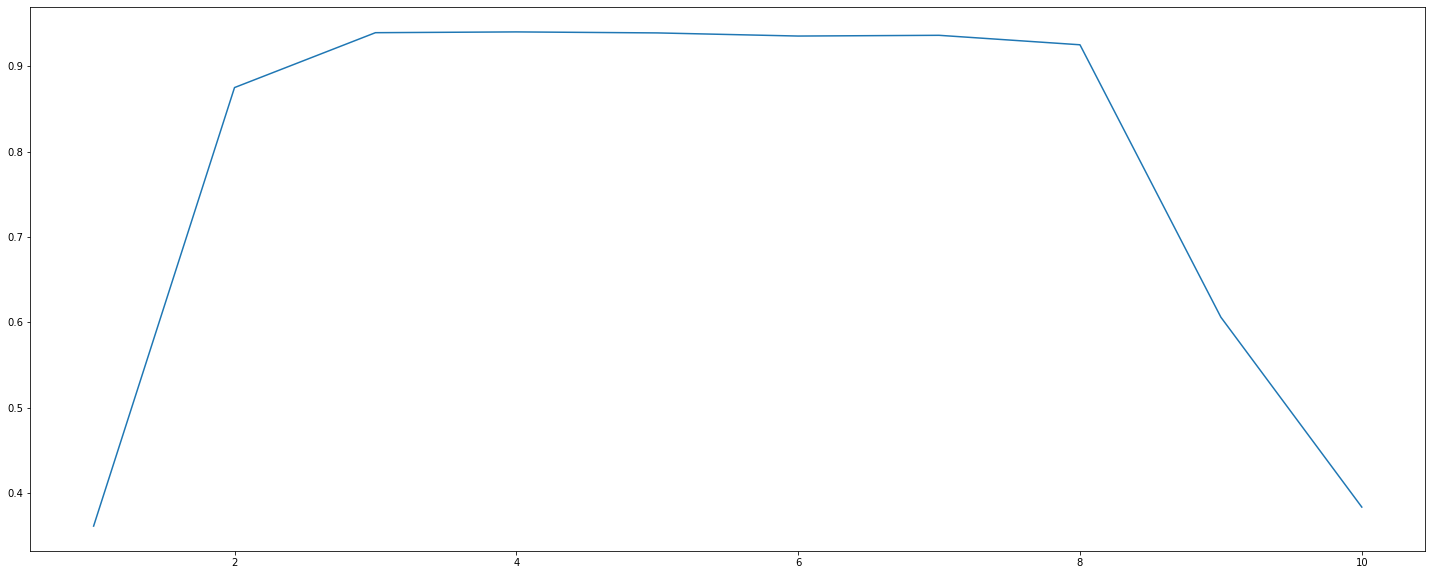

In [38]:
FSCORE = pd.DataFrame()
for k in sfs.get_metric_dict():
    fscore = sfs.get_metric_dict()[k]['avg_score']
    FSCORE = FSCORE.append([fscore])

FSCORE.columns = ['avg score']
FSCORE.reset_index(drop=True, inplace=True)
FSCORE.index = FSCORE.index+1

# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(FSCORE)

In [39]:
FSCORE

,avg score
1,0.361016
2,0.875041
3,0.939369
4,0.940281
5,0.939101
6,0.935432
7,0.936294
8,0.925193
9,0.605867
10,0.383303


**Forward stepwise regression has the highest $R^2$ for n = 4.**

In [40]:
dfX.columns

Index(['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10'], dtype='object')

In [41]:
feat = sfs.k_feature_idx_
feat

(0, 1, 2, 9)

In [42]:
feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X^2
X^3
X^10


,Features
0,X
1,X^2
2,X^3
3,X^10


*It's interesting to note that forward stepwise regression returns 2 additional predictors compared with the best subset selection based on $R^2$.*

In [43]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-2.103748,2.231123
1,X^2,2.794190,2.231123
2,X^3,2.612231,2.231123
3,X^10,0.000629,2.231123


In [44]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.807


**Therefore, the best equation through forward stepwise selection is $Y$ = 2.231123 - 2.103748 $X$ + 2.79419 $X^2$ + 0.000629 $X^10$ and the mean squared error is 0.807.**

**Backward stepwise selection**

In [50]:
lmb = LinearRegression()
bfs = SFS(lmb, k_features=(1,len(dfX.columns)), forward=False, floating=False, scoring='r2',cv=5).fit(dfX.values, dfY)

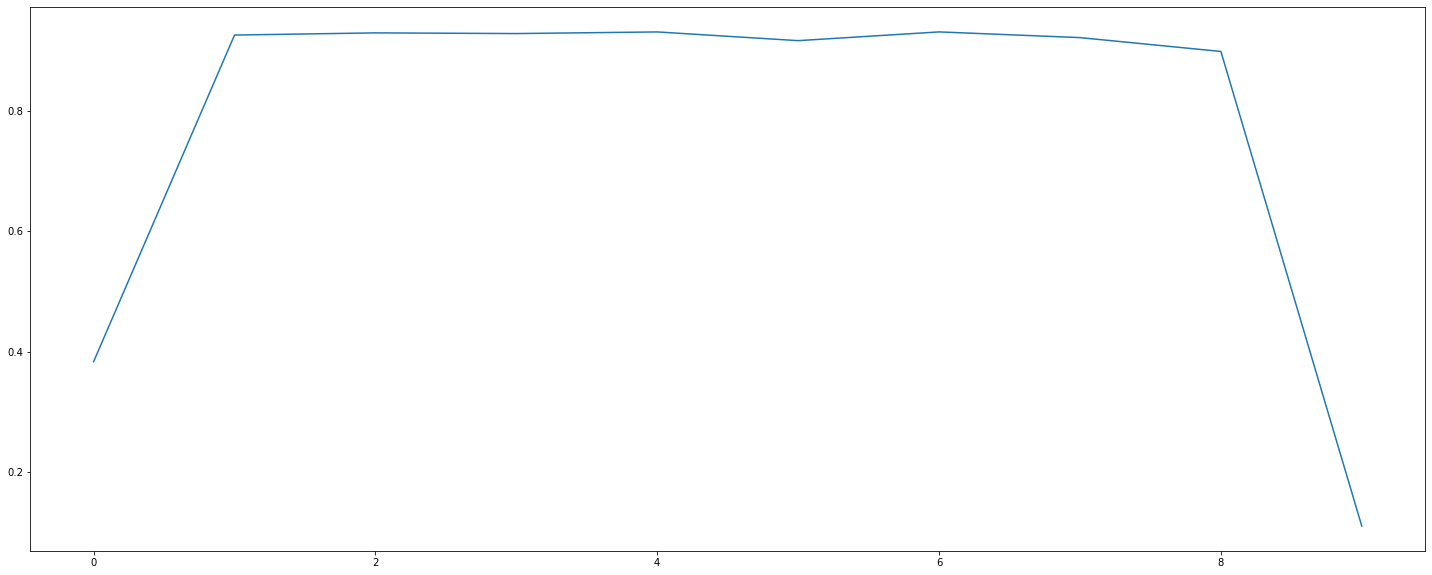

In [58]:
BSCORE = pd.DataFrame()
for k in bfs.get_metric_dict():
    bscore = bfs.get_metric_dict()[k]['avg_score']
    BSCORE = BSCORE.append([bscore])

BSCORE.columns = ['avg score']
BSCORE.reset_index(drop=True, inplace=True)
# BSCORE.index = BSCORE.index+1

# plt.xkcd()
plt.figure(figsize=(25, 10))
plt.plot(BSCORE)

In [59]:
BSCORE

,avg score
0,0.383303
1,0.925915
2,0.929542
3,0.928410
4,0.931110
5,0.916643
6,0.931157
7,0.921692
8,0.898670
9,0.110060


**Backward stepwise regression has the highest $R^2$ for n = 4.**

In [60]:
dfX.columns

Index(['X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10'], dtype='object')

In [61]:
feat = bfs.k_feature_idx_
feat

(0, 1, 4, 6)

In [62]:
feat_list = pd.DataFrame()
for i in feat:
    print(dfX.columns[i])
    feat_list = feat_list.append(pd.DataFrame([dfX.columns[i]]))
feat_list.reset_index(inplace=True, drop=True)
feat_list.columns = ['Features']
feat_list

X
X^2
X^5
X^7


,Features
0,X
1,X^2
2,X^5
3,X^7


*It's interesting to note that backward stepwise regression returns the same predictors as that of best subset selection  and forward stepwise selection based on $R^2$.*

In [63]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_]*4)
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X,-0.748461,2.16192
1,X^2,2.999204,2.16192
2,X^5,1.110472,2.16192
3,X^7,-0.130604,2.16192


In [64]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  0.937


**Therefore, the best equation through backward stepwise selection is $Y$ = 2.16192 - 0.748461 $X$ + 2.999204 $X^2$ + 1.110472 $X^5$ - 0.130604 $X^7$ and the mean squared error is 0.937.**

### 8.d. Lasso regression

In [65]:
# import custom packages
from sklearn.linear_model import Lasso

In [66]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(dfX)
dfX_scaled = scaler.transform(dfX)

In [67]:
n = 100
lambdas = (np.logspace(10, -2, num=100))

In [68]:
coefs = []
MSE = []
for k in lambdas:
    lassomod = Lasso(alpha=k, fit_intercept=True).fit(dfX_scaled,dfY)
    coefs.append(lassomod.coef_)
    MSE.append(mean_squared_error(dfY, lassomod.predict(dfX_scaled)))

In [69]:
coefPD = pd.DataFrame(coefs)

In [70]:
coefPD.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
coefPD.shape

(100, 10)

In [72]:
lassomod.intercept_

array([4.74193075])

In [73]:
coefPD = pd.concat([pd.DataFrame([lassomod.intercept_]*100), coefPD], axis=1)
coefPD.columns = ['Intercept', 'X', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
coefPD.shape

(100, 11)

In [74]:
coefPD.head()

,Intercept,X,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10
0,4.741931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.741931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.741931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.741931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.741931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


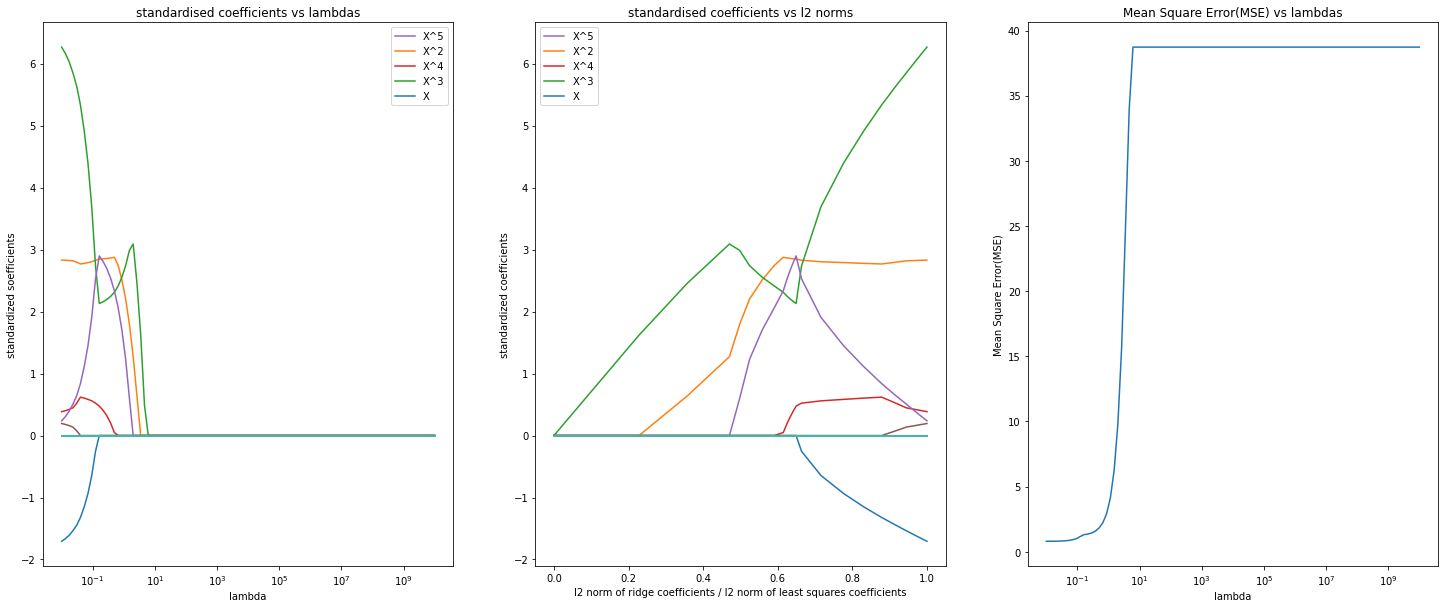

In [75]:
# plt.xkcd()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))

# indexing the five largest coefficients
idx = np.argpartition(np.abs(coefs[-1]), -5)[-5:]

# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('standardized soefficients')
ax1.set_title('standardised coefficients vs lambdas')
ax1.legend(np.array(ax1.get_lines())[idx], dfX.columns[idx])

# standardised coefficients vs l2 norms
l2norm = np.linalg.norm(coefs[-1])
l2coefs = np.linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], dfX.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.3, random_state=42)

In [77]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
# MSE with only the intercept
lmMSEintercept = np.mean(pow((y_train.mean()-y_test), 2))
print("MSE with only the intercept: ", lmMSEintercept)

# MSE for lambda = 0; this is similar to least squares linear regression
lmlasso0 = Lasso(alpha=0, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict0 = lmlasso0.predict(X_test_scaled)
lmMSE0 = mean_squared_error(y_test, lmpredict0)
print("MSE at lambda = 0: ", lmMSE0)

# MSE for lambda = 1
lmridge1 = Lasso(alpha=1, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1 = lmridge1.predict(X_test_scaled)
lmMSE1 = mean_squared_error(y_test, lmpredict1)
print("MSE at lambda = 1: ", lmMSE1)

# MSE for lambda = 4
lmlasso4 = Lasso(alpha=4, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict4 = lmlasso4.predict(X_test_scaled)
lmMSE4 = mean_squared_error(y_test, lmpredict4)
print("MSE at lambda = 4: ", lmMSE4)

# MSE for lambda = pow(10, 10)
lmlasso1010 = Lasso(alpha=pow(10, 10), fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1010 = lmlasso1010.predict(X_test_scaled)
lmMSE1010 = mean_squared_error(y_test, lmpredict1010)
print("MSE at lambda = 10^10: ", lmMSE1010)

MSE with only the intercept:  Y    10.171203
dtype: float64
MSE at lambda = 0:  1.3229624818944952
MSE at lambda = 1:  1.3215630892926427
MSE at lambda = 4:  6.641384747408003
MSE at lambda = 10^10:  10.171203383392053


In [79]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV

lmlassoCV = LassoCV(alphas=lambdas, cv=10).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", lmlassoCValpha)

Best lambda:  0.01


In [80]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha=lmlassoCValpha, fit_intercept=True).fit(X_train_scaled, y_train)
lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  1.265


In [81]:
intercept_list = pd.DataFrame([lmlasso.intercept_]*10)
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1
coef_list

,Intercept,Coefficients
1,4.916213,-1.688878
2,4.916213,3.831051
3,4.916213,6.472919
4,4.916213,0.000000
5,4.916213,0.883097
6,4.916213,0.000000
7,4.916213,0.000000
8,4.916213,0.000000
9,4.916213,-0.000000
10,4.916213,0.114530


**Therefore, the best equation through lasso regression is $Y$ = 4.916213 - 1.688878 $X$ + 3.831051 $X^2$ + 6.472919 $X^3$ + 0.883097 $X^5$ + 0.114530 $X^{10}$ and the mean squared error is 1.265.**

### 8.f. Best subset selection and lasso regression for for $Y$ = $\beta_0$ + $\beta_7$ $X^7$ + $\epsilon$

In [82]:
BETA7 = 23.457
Y7 = BETA0 + (BETA7*pow(X, 7)) + epsilon

**Best subset selection**

In [83]:
dfX7 = pd.DataFrame([pow(X, 7)]).T
dfX7.columns = ['X^7']
dfY7 = pd.DataFrame([Y7]).T
dfY7.columns = ['Y']

In [84]:
lm = LinearRegression()
efs = EFS(lm, min_features=1, max_features=1, scoring='r2', cv=5).fit(dfX7, dfY7)

Features: 1/1

In [85]:
SCORE = pd.DataFrame()
for k in efs.get_metric_dict():
    score = efs.get_metric_dict()[k]['std_err']
    SCORE = SCORE.append([score])

SCORE.columns = ['std err']
SCORE.reset_index(drop=True, inplace=True)

In [86]:
minSCORE = SCORE.loc[SCORE['std err'] == min(SCORE['std err'])]
minSCORE

,std err
0,0.000324


In [87]:
efs.subsets_[0]

{'feature_idx': (0,),
 'cv_scores': array([0.99999972, 0.99996709, 0.99999913, 0.99999952, 0.9983734 ]),
 'avg_score': 0.9996677699131767,
 'feature_names': ('X^7',)}

In [88]:
features = efs.best_feature_names_
idx = efs.best_idx_

feat_list = pd.concat([pd.DataFrame([features]).T, pd.DataFrame([idx]).T], axis = 1)
feat_list.columns = ['Features', 'Index']
avg_score = pd.DataFrame()
for i in idx:
    avg_score = avg_score.append(pd.DataFrame([efs.subsets_[i]['avg_score']]))
avg_score.columns = ['Average Score']
avg_score.reset_index(drop=True,inplace=True)
feat_list = pd.concat([feat_list, avg_score], axis=1, ignore_index=True)
feat_list.columns = ['Features', 'Index', 'Average Score']
feat_list

,Features,Index,Average Score
0,X^7,0,0.999668


In [89]:
# performing linear regression on best features
dfX_reg = dfX[feat_list['Features']]

lm_best = LinearRegression().fit(dfX_reg, dfY)
final_coefs = pd.DataFrame(lm_best.coef_).T
final_coefs = pd.concat([feat_list['Features'], final_coefs], axis = 1)
final_intercept = pd.DataFrame([lm_best.intercept_])
final_coefs = pd.concat([final_coefs, final_intercept], axis = 1)
final_coefs.columns = ['Features', 'Coefficients', 'Intercept']
final_coefs

,Features,Coefficients,Intercept
0,X^7,0.089695,4.784395


In [90]:
lmpred = lm_best.predict(dfX_reg)
print("Mean Squared Error: ", round(mean_squared_error(dfY, lmpred), 3))

Mean Squared Error:  18.038


**Therefore, the best equation through best subset selection is $Y$ = 4.784395 + 0.089695 $X^7$ and the mean squared error is 18.038.**

**Lasso regression**

In [91]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(dfX7)
dfX7_scaled = scaler.transform(dfX7)

In [92]:
n = 100
lambdas = (np.logspace(10, -2, num=100))

In [93]:
coefs = []
MSE = []
for k in lambdas:
    lassomod = Lasso(alpha=k, fit_intercept=True).fit(dfX7_scaled,dfY7)
    coefs.append(lassomod.coef_)
    MSE.append(mean_squared_error(dfY7, lassomod.predict(dfX7_scaled)))

In [94]:
coefPD = pd.DataFrame(coefs)

In [95]:
coefPD.head()

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [96]:
coefPD.shape

(100, 1)

In [97]:
lassomod.intercept_

array([-8.95252135])

In [98]:
coefPD = pd.concat([pd.DataFrame([lassomod.intercept_]*100), coefPD], axis=1)
coefPD.columns = ['Intercept', 'X^7']
coefPD.shape

(100, 2)

In [99]:
coefPD.head()

,Intercept,X^7
0,-8.952521,0.0
1,-8.952521,0.0
2,-8.952521,0.0
3,-8.952521,0.0
4,-8.952521,0.0


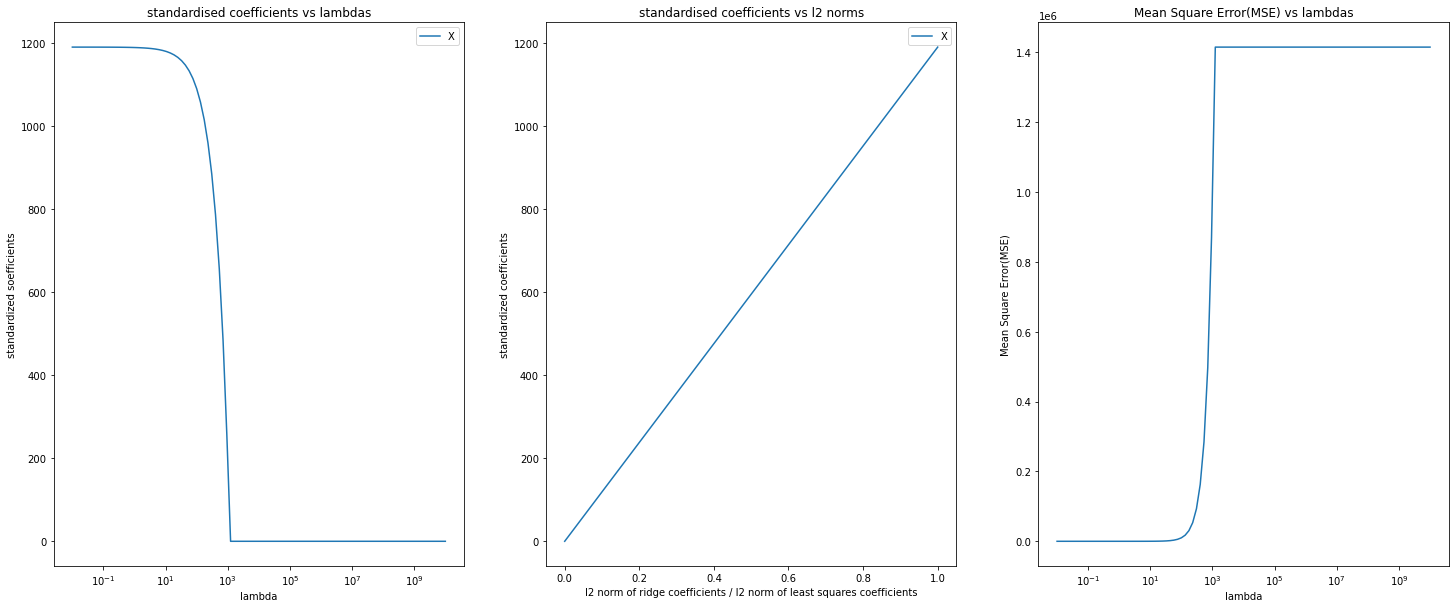

In [100]:
# plt.xkcd()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,10))

# indexing the only coefficient
idx = np.argpartition(np.abs(coefs[-1]), -1)[-1:]

# standardised coefficients vs lambdas
ax1.plot(lambdas, coefs)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('standardized soefficients')
ax1.set_title('standardised coefficients vs lambdas')
ax1.legend(np.array(ax1.get_lines())[idx], dfX.columns[idx])

# standardised coefficients vs l2 norms
l2norm = np.linalg.norm(coefs[-1])
l2coefs = np.linalg.norm(coefs/l2norm, axis=1)
ax2.plot(l2coefs, coefs)
ax2.set_xlabel('l2 norm of ridge coefficients / l2 norm of least squares coefficients')
ax2.set_ylabel('standardized coefficients')
ax2.set_title('standardised coefficients vs l2 norms')
ax2.legend(np.array(ax2.get_lines())[idx], dfX.columns[idx]);

# 'Mean Square Error(MSE) vs lambdas
ax3.plot(lambdas, MSE)
ax3.set_xscale('log')
ax3.set_xlabel('lambda')
ax3.set_ylabel('Mean Square Error(MSE)')
ax3.set_title('Mean Square Error(MSE) vs lambdas');

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX7, dfY7, test_size=0.3, random_state=42)

In [102]:
# standardisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [103]:
# MSE with only the intercept
lmMSEintercept = np.mean(pow((y_train.mean()-y_test), 2))
print("MSE with only the intercept: ", lmMSEintercept)

# MSE for lambda = 0; this is similar to least squares linear regression
lmlasso0 = Lasso(alpha=0, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict0 = lmlasso0.predict(X_test_scaled)
lmMSE0 = mean_squared_error(y_test, lmpredict0)
print("MSE at lambda = 0: ", lmMSE0)

# MSE for lambda = 1
lmridge1 = Lasso(alpha=1, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1 = lmridge1.predict(X_test_scaled)
lmMSE1 = mean_squared_error(y_test, lmpredict1)
print("MSE at lambda = 1: ", lmMSE1)

# MSE for lambda = 4
lmlasso4 = Lasso(alpha=4, fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict4 = lmlasso4.predict(X_test_scaled)
lmMSE4 = mean_squared_error(y_test, lmpredict4)
print("MSE at lambda = 4: ", lmMSE4)

# MSE for lambda = pow(10, 10)
lmlasso1010 = Lasso(alpha=pow(10, 10), fit_intercept=True).fit(X_train_scaled, y_train)
lmpredict1010 = lmlasso1010.predict(X_test_scaled)
lmMSE1010 = mean_squared_error(y_test, lmpredict1010)
print("MSE at lambda = 10^10: ", lmMSE1010)

MSE with only the intercept:  Y    26931.921085
dtype: float64
MSE at lambda = 0:  1.1346290601263855
MSE at lambda = 1:  1.146009895322998
MSE at lambda = 4:  1.340895697538563
MSE at lambda = 10^10:  26931.921085017148


In [104]:
# finding the best lambda using CV
from sklearn.linear_model import LassoCV

lmlassoCV = LassoCV(alphas=lambdas, cv=10).fit(X_train_scaled, y_train)
lmlassoCValpha = lmlassoCV.alpha_
print("Best lambda: ", lmlassoCValpha)

Best lambda:  0.12328467394420634


In [105]:
# performing lasso regression using best lambda
lmlasso = Lasso(alpha=lmlassoCValpha, fit_intercept=True).fit(X_train_scaled, y_train)
lmlasso_MSE = mean_squared_error(y_test, lmlasso.predict(X_test_scaled))
print('MSE for best lambda: ', round(lmlasso_MSE, 3))

MSE for best lambda:  1.135


In [106]:
intercept_list = pd.DataFrame([lmlasso.intercept_])
coef_list = pd.concat([intercept_list, pd.DataFrame([lmlasso.coef_]).T], axis = 1)
coef_list.reset_index(inplace=True, drop=True)
coef_list.columns = ['Intercept', 'Coefficients']
coef_list.index = coef_list.index+1
coef_list

,Intercept,Coefficients
1,-21.577303,1417.862041


**Therefore, the best equation through lasso regression is $Y$ = -21.577303 + 1417.882041 $X^7$ and the mean squared error is 1.135.**

**This suggests that when p<<n, then lasso provides a better fit (even if the intercept is quite off from its true value)
than best subset selection as suggested by the lower MSE through lasso regression. But, as p  increases to the point of
p$\approx$n, then best subset selection is more preferred, albeit it comes at a cost of greater computational requirement.**